0. outside the notebook: 
    (with the final resmico model)
    produce and save predictions and embeddings with flags: --embeddings --emb-ind=-4
    now, only 10k samples will get predictions and indecies are not needed  
1. load csv for novel family and cami data
2. add 'avg_coverage' info using contig reader (will not work if it was not filled for new dataset)
3. change embedding format and create 'new' column
4. fit 2d umap on train data
5. transform other data
6. plot results


In [1]:
import umap
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

2022-02-06 21:46:26.912139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import contig_reader
from resmico import models_fl as Models

In [3]:
sns.set_theme(font_scale=1.2, style="white")

In [4]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')

In [5]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'
pred_path = project_path + 'Outputs/predictions/'

In [6]:
preds_df_train = pd.read_csv(pred_path+'emb-train-mc40_aucPR_0.727.csv')
preds_df_novel = pd.read_csv(pred_path+'emb-novel-mc40_aucPR_0.727.csv')
preds_df_gut = pd.read_csv(pred_path+'emb-gut-mc40_aucPR_0.727.csv')

In [7]:
preds_df_train['new'] = preds_df_train['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))
preds_df_novel['new'] = preds_df_novel['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))
preds_df_gut['new'] = preds_df_gut['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))

In [8]:
preds_df_train['cont_name'] = preds_df_train['cont_name'].apply(lambda x: x.replace('//','/'))

In [9]:
preds_df_train['tech'] = preds_df_train['cont_name'].apply(lambda x: x.split('/')[-2])
preds_df_train['sd'] = preds_df_train['cont_name'].apply(lambda x: x.split('/')[-3])
preds_df_train['read'] = preds_df_train['cont_name'].apply(lambda x: x.split('/')[-4])
preds_df_train['abd'] = preds_df_train['cont_name'].apply(lambda x: x.split('/')[-6])
preds_df_train['rch'] = preds_df_train['cont_name'].apply(lambda x: x.split('/')[-7])

In [10]:
reducer = umap.UMAP(n_neighbors=15, random_state=111)

In [11]:
emb_data_train = np.stack(preds_df_train.new.values)
emb_data_novel = np.stack(preds_df_novel.new.values)
emb_data_gut = np.stack(preds_df_gut.new.values)

In [12]:
emb_data_train.shape, emb_data_novel.shape, emb_data_gut.shape

((10000, 128), (10000, 128), (10000, 128))

In [13]:
dim2_emb_train = reducer.fit_transform(emb_data_train)
dim2_emb_train.shape

(10000, 2)

In [14]:
dim2_emb_novel = reducer.transform(emb_data_novel)
dim2_emb_gut = reducer.transform(emb_data_gut)
dim2_emb_gut.shape

(10000, 2)

In [15]:
def compute_mean(contig_data):
    feature = 'coverage'

    contig = reader.read_contigs([contig_data], return_raw=True)[0]
    features_stats = {}
    features_stats[feature] = {'sum':0, 'count':0}
    
    #for runs with 1 feature
    minval = 10**8
    maxval = -10**8

    cur_max = np.nanmax(contig[feature])
    cur_min = np.nanmin(contig[feature])
    minval = np.min((minval,cur_min))
    maxval = np.max((maxval,cur_max))

    features_stats[feature]['sum'] += np.nansum(contig[feature])
    features_stats[feature]['count'] += (len(contig[feature]) -
                                             np.count_nonzero(np.isnan(contig[feature])))

#     print(minval, maxval)
#     print(features_stats)

    feat_sum = features_stats[feature]['sum']
    n_el = features_stats[feature]['count']
       
    return feat_sum / n_el

def cov_2_dic(ind):
    contig = reader.contigs[ind]
    name = contig.file[:-len('features_binary')]+contig.name
    if name in cont_name_set:
        if ind%500==0:
            print(ind)
        if contig.avg_coverage == 100:
            avg_coverage = compute_mean(contig)
        else:
            avg_coverage = contig.avg_coverage
            
        return (name, avg_coverage)

In [16]:
cont_name_set = set(preds_df_train['cont_name'])

In [17]:
feature_files_path = project_path + 'data/v2/resmico-sm/GTDBr202_n9k_train/'
reader = contig_reader.ContigReader(feature_files_path, ['coverage'], process_count=1, 
                                    is_chunked=False)

In [18]:
import multiprocessing as mp

pool = mp.Pool(16)
inputs = np.arange(len(reader))
train_name2cov = [x for x in pool.map(cov_2_dic, inputs) if x is not None]
train_name2cov = dict(train_name2cov)
print('len: ', len(train_name2cov))

1616000
3236500
3181500
4200500
5646500
12523500
12853500
14294000
17009000
len:  10000


In [19]:
preds_df_train['avg_coverage'] = preds_df_train['cont_name'].map(train_name2cov)

In [20]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')

In [21]:
save_path=project_path+'Outputs/figures'

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/umap_joined.pdf


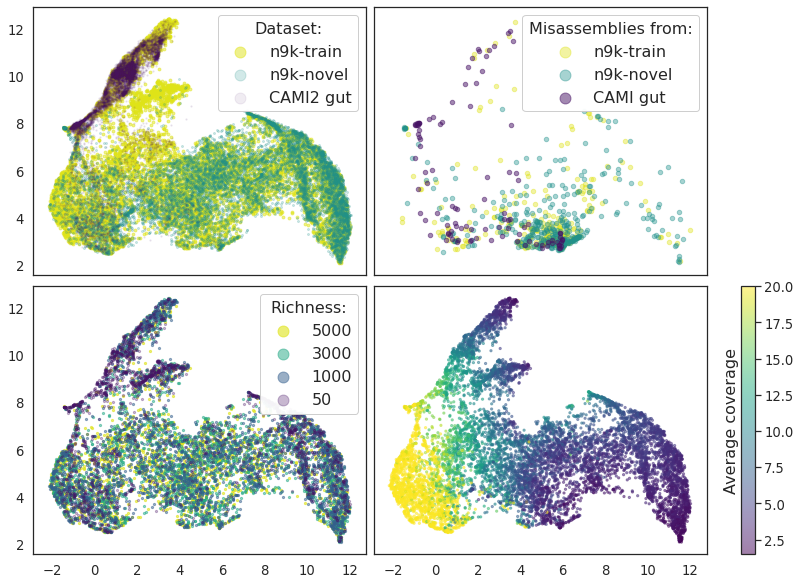

In [22]:
#plot joint
fig, axs = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True,
                                    sharey = True, sharex = True)

axs[0][0].scatter(
    dim2_emb_train[:, 0], dim2_emb_train[:, 1],
    alpha=0.5, c=cmap(0.95), s=8,
    label = 'n9k-train')

axs[0][0].scatter(
    dim2_emb_novel[:, 0], dim2_emb_novel[:, 1],
    alpha=0.2, c=cmap(0.5), s=4,
    label = 'n9k-novel')

axs[0][0].scatter(
    dim2_emb_gut[:, 0], dim2_emb_gut[:, 1], alpha=0.08,
    c=cmap(0.05), s=2, label = 'CAMI2 gut')

#plot errors
axs[0][1].scatter(
    dim2_emb_train[:, 0][preds_df_train.label>0], 
    dim2_emb_train[:, 1][preds_df_train.label>0],
    c=cmap(0.95), s=20, alpha=0.4,
    label = 'n9k-train')

axs[0][1].scatter(
    dim2_emb_novel[:, 0][preds_df_novel.label>0], 
    dim2_emb_novel[:, 1][preds_df_novel.label>0],
    c=cmap(0.5), s=20, alpha=0.4,
    label = 'n9k-novel')

axs[0][1].scatter(
    dim2_emb_gut[:, 0][preds_df_gut.label>0], 
    dim2_emb_gut[:, 1][preds_df_gut.label>0], 
    c=cmap(0.05), s=20, alpha=0.5,
    label = 'CAMI gut')

rch_col = {'0.111111':2, '0.333333':3, '0.555555':4, '0.005555':1}

#plot richness
keys = sorted(list(rch_col.keys()))
i=3
inds = preds_df_train.rch == keys[i]
axs[1][0].scatter(
    dim2_emb_train[inds][:, 0], dim2_emb_train[inds][:, 1], c=cmap(0.95),
    alpha=0.6, s=5, label = round(9000*float(keys[i])))
i=2
inds = preds_df_train.rch == keys[i]
axs[1][0].scatter(
    dim2_emb_train[inds][:, 0], dim2_emb_train[inds][:, 1], c=cmap(0.6),
    alpha=0.5, s=5, label = round(9000*float(keys[i])))
i=1
inds = preds_df_train.rch == keys[i]
axs[1][0].scatter(
    dim2_emb_train[inds][:, 0], dim2_emb_train[inds][:, 1], c=cmap(0.3),
    alpha=0.5, s=5, label = round(9000*float(keys[i])))
i=0
inds = preds_df_train.rch == keys[i]
axs[1][0].scatter(
    dim2_emb_train[inds][:, 0], dim2_emb_train[inds][:, 1], c=cmap(0.05),
    alpha=0.3, s=5, label = round(9000*float(keys[i])))



m = axs[1][1].scatter(
    dim2_emb_train[:, 0], dim2_emb_train[:, 1],
    alpha=0.5,
    c=preds_df_train.avg_coverage,
    s=5, cmap=cmap,
    label = 'n9k')


lgnd = axs[0][0].legend(fontsize=16, title = "Dataset:", title_fontsize = 16, 
                        loc='upper right', framealpha=0.95)
for handle in lgnd.legendHandles:
    handle.set_sizes([120])
lgnd = axs[0][1].legend(fontsize=16, title = "Misassemblies from:", title_fontsize = 16, 
                        loc='upper right', framealpha=0.95)
for handle in lgnd.legendHandles:
    handle.set_sizes([120])
lgnd = axs[1][0].legend(fontsize=16, title = "Richness:", title_fontsize = 16, 
                        loc='upper right', framealpha=0.95)
for handle in lgnd.legendHandles:
    handle.set_sizes([120])
# cbar = plt.colorbar(m, orientation="vertical")
cbar=fig.colorbar(m, ax=[axs[1, 1]], location='right')
cbar.ax.set_ylabel('Average coverage', rotation=90, fontsize=16, labelpad=-70)




where = os.path.join(save_path,'umap_joined.pdf')
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

plt.show()

In [23]:
# # feature_files_path = project_path + 'data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/'
# feature_files_path = project_path + 'data/v2/resmico-sm/GTDBr202_n9k_train/'
# reader = contig_reader.ContigReader(feature_files_path, ['coverage'], process_count=1, 
#                                     is_chunked=False)

# family_name2cov = {}
# # family_name2gc = {}

# cont = 0   
# wrongcov = 0
# for ind in range(len(reader)):
#     contig = reader.contigs[ind]
#     name = contig.file[:-len('features_binary')]+contig.name
#     if name in set(preds_df_train['cont_name']):
#         count+=1
#         if count%100==0:
#             print(count)
#         if contig.avg_coverage == 100:
#             if wrongcov == 0:
#                 wrongcov = 1
#                 print('100!!!!!')
#             avg_coverage = compute_mean(contig)
#             family_name2cov[name] = avg_coverage
#         else:
#             family_name2cov[name] = contig.avg_coverage
# #     family_name2gc[name] = gc(ind, reader)
    
# # #cami error
# # feature_files_path = project_path + 'data/v2/resmico-sm/GTDBr202_n9k_train/cami_err/features/'
# # reader = contig_reader.ContigReader(feature_files_path, ['ref_base'], process_count=1, 
# #                                     is_chunked=False)

# # cami_error_name2cov = {}
# # for contig in reader.contigs:
# #     cami_error_name2cov[contig.file[:-len('features_binary')]+contig.name] = contig.avg_coverage
    
    
# # # #oral
# # # feature_files_path = project_path + 'data/CAMI/CAMI2_HMP-oral/short_read/ResMiCo-SM/features/'
# # # reader = contig_reader.ContigReader(feature_files_path, ['coverage'], process_count=1, 
# # #                                     is_chunked=False)

# # # oral_name2cov = {}
# # # for contig in reader.contigs:
# # #     oral_name2cov[contig.file[:-len('features_binary')]+contig.name] = contig.avg_coverage
# # # gut    
# # feature_files_path = project_path + 'data/CAMI/CAMI2_HMP-gut/short_read/ResMiCo-SM/features/'
# # reader = contig_reader.ContigReader(feature_files_path, ['ref_base'], process_count=1, 
# #                                     is_chunked=False)
# # gut_name2cov = {}
# # # gut_name2gc = {}
# # for ind in sel_ind_g:
# #     contig = reader.contigs[ind]
# #     name = contig.file[:-len('features_binary')]+contig.name
# #     gut_name2cov[name] = contig.avg_coverage
# # #     gut_name2gc[name] = gc(ind, reader)

# # # #skin    
# # # feature_files_path = project_path + 'data/CAMI/CAMI2_HMP-skin/short_read/ResMiCo-SM/features/'
# # # reader = contig_reader.ContigReader(feature_files_path, ['coverage', 'ref_base'], process_count=1, 
# # #                                     is_chunked=False)

# # # skin_name2cov = {}
# # # for contig in reader.contigs:
# # #     skin_name2cov[contig.file[:-len('features_binary')]+contig.name] = contig.avg_coverage

In [24]:
# convoluted_size = lambda len, pad: 0
# def gc(ind, reader):
#     predict_data = Models.BinaryDatasetEval(reader, [ind], ['ref_base'], 5000, max(250, 5000-500),
#                                             int(3 * 1e9 * 0.8), cache_results=False,
#                                             show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=False)
#     cf = predict_data.__getitem__(0)
#     #['ref_base_A', 'ref_base_C', 'ref_base_G', 'ref_base_T']
#     return np.mean(cf[0][0][0][:,1] + cf[0][0][0][:,2])

In [25]:
# preds_df['gc'] = preds_df['cont_name'].map(family_name2gc)
# preds_df_gut['gc'] = preds_df_gut['cont_name'].map(gut_name2gc)